In [1]:
import lightgbm as lgb
import pandas as pd
from io import StringIO
import numpy as np
import pickle 
import numpy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
with open('pickles/features_train.pkl', 'rb') as f:
    features_train = pickle.load(f)

with open('pickles/labels_train.pickle', 'rb') as f:
    labels_train = pickle.load(f)

with open('pickles/features_test.pkl', 'rb') as f:
    features_test = pickle.load(f)

with open('pickles/labels_test.pkl', 'rb') as f:
    labels_test = pickle.load(f)

In [4]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [5]:
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [7]:
opt_parameters = {'colsample_bytree': 0.9234, 'min_child_samples': 399, 'min_child_weight': 0.1, 'num_leaves': 13, 'reg_alpha': 2, 'reg_lambda': 5, 'subsample': 0.855}

In [8]:
clf_sw = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_sw.set_params(**opt_parameters)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9234,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metric='None', min_child_samples=399, min_child_weight=0.1,
               min_split_gain=0.0, n_estimators=5000, n_jobs=4, num_leaves=13,
               objective=None, random_state=314, reg_alpha=2, reg_lambda=5,
               silent=True, subsample=0.855, subsample_for_bin=200000,
               subsample_freq=0)

In [15]:
gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='accuracy',
                                cv=5,
                                refit=True,
                                verbose=True)

In [23]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [29]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'accuracy', 
            "eval_set" : [(features_test,labels_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [30]:
gs_sample_weight.fit(features_train, labels_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kevin/anaconda3/envs/gpu/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Multiclass objective and metrics don't match

  FitFailedWarning)
/home/kevin/anaconda3/envs/gpu/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Multiclass objective and metrics don't match

  FitFailedWarning)
/home/kevin/anaconda3/envs/gpu/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError

LightGBMError: Multiclass objective and metrics don't match

In [26]:
print("Valid+-Std     Train  :   Parameters")
for i in np.argsort(gs_sample_weight.cv_results_['mean_test_score'])[-5:]:
    print('{1:.3f}+-{3:.3f}     {2:.3f}   :  {0}'.format(gs_sample_weight.cv_results_['params'][i], 
                                    gs_sample_weight.cv_results_['mean_test_score'][i], 
                                    gs_sample_weight.cv_results_['mean_train_score'][i],
                                    gs_sample_weight.cv_results_['std_test_score'][i]))

Valid+-Std     Train  :   Parameters


KeyError: 'mean_train_score'

In [27]:
clf_final = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final.fit(features_train, labels_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

Training until validation scores don't improve for 30 rounds
[100]	valid's multi_logloss: 2.47713
[200]	valid's multi_logloss: 2.47589
[300]	valid's multi_logloss: 2.47548
[400]	valid's multi_logloss: 2.47529
[500]	valid's multi_logloss: 2.47518
[600]	valid's multi_logloss: 2.47512
[700]	valid's multi_logloss: 2.47508
[800]	valid's multi_logloss: 2.47506
[900]	valid's multi_logloss: 2.47505
[1000]	valid's multi_logloss: 2.47504
[1100]	valid's multi_logloss: 2.47503
[1200]	valid's multi_logloss: 2.47503
[1300]	valid's multi_logloss: 2.47502
[1400]	valid's multi_logloss: 2.47501
[1500]	valid's multi_logloss: 2.475
[1600]	valid's multi_logloss: 2.47499
[1700]	valid's multi_logloss: 2.47498
[1800]	valid's multi_logloss: 2.47498
[1900]	valid's multi_logloss: 2.47497
[2000]	valid's multi_logloss: 2.47496
[2100]	valid's multi_logloss: 2.47495
[2200]	valid's multi_logloss: 2.47494
[2300]	valid's multi_logloss: 2.47494
[2400]	valid's multi_logloss: 2.47493
[2500]	valid's multi_logloss: 2.47492


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9234,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metric='None', min_child_samples=399, min_child_weight=0.1,
               min_split_gain=0.0, n_estimators=5000, n_jobs=4, num_leaves=13,
               objective=None, random_state=314, reg_alpha=2, reg_lambda=5,
               silent=True, subsample=0.855, subsample_for_bin=200000,
               subsample_freq=0)

The training accuracy is: 
0.114540059347181
The test accuracy is: 
0.12085308056872038
Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.28      0.11      0.16        45
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        32
           4       0.00      0.00      0.00        43
           5       0.00      0.00      0.00        37
           6       0.00      0.00      0.00        45
           7       0.10      0.74      0.17        38
           8       0.00      0.00      0.00        44
           9       0.00      0.00      0.00        38
          10       0.15      0.42      0.22        43

    accuracy                           0.12       422
   macro avg       0.05      0.12      0.05       422
weighted avg       0.05      0.12      0.06       422



/home/kevin/anaconda3/envs/gpu/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


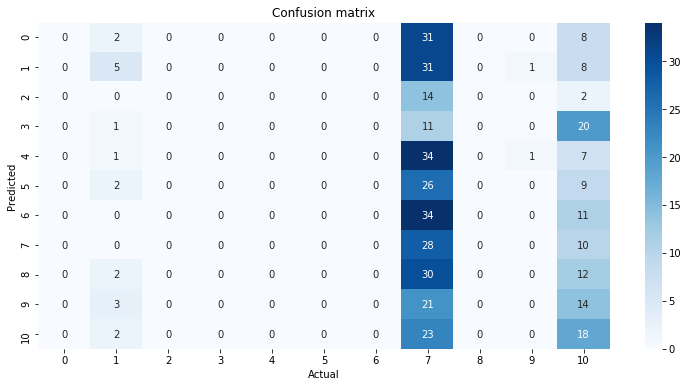

In [28]:
estimator = clf_final
prediction_2 = estimator.predict(features_test)
print("The training accuracy is: ")
print(accuracy_score(labels_train, estimator.predict(features_train)))
print("The test accuracy is: ")
print(accuracy_score(labels_test, prediction_2))
print("Classification report")
print(classification_report(labels_test,prediction_2))

conf_matrix = confusion_matrix(labels_test, prediction_2)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()